In [ ]:
from s_getdata import GetData
from data_preprocess import Scaler, DataPreprocess, TimeSeriesDataset, ModelData, Scaler
from model import LSTMModel
from train import Models, Dataloaders, Trainer, TrainerAll
from configs import config, stocks
from utils import Normalizer, DataPrep


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

Number data points: 6302 from 1999-11-01 to 2024-11-15


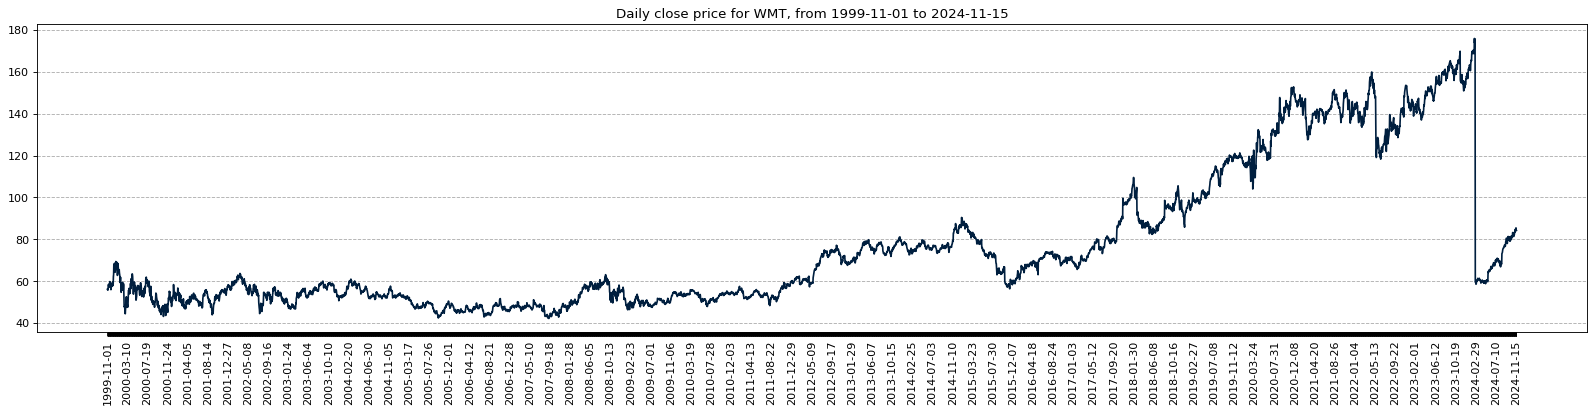

In [2]:
def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()
    # print(data)
    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

# Getting Data and Model

In [3]:
data_close_price.shape

(6302,)

In [4]:
# Get Data
getdata = GetData()

dates, data = getdata.get_data()
print(data['Walmart'].shape)
print(dates.shape)

(6291,)
(6291,)


In [6]:
data_preprocess = DataPreprocess()
splitting = DataPrep()
# Scale Data
scaler = Scaler().scalers()['Walmart']

# scaled_data = scaler.fit_transform(data['Amazon'].reshape(-1, 1)).flatten()

scaled_data = scaler.fit_transform(data_close_price.reshape(-1, 1)).flatten()

# split data
X_unseen, X_train, X_test, y_train, y_test = splitting.prepare_data(scaled_data, config)
X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

# Create Train and Test Dataset
train_data= TimeSeriesDataset(X_train, y_train)
test_data = TimeSeriesDataset(X_test, y_test)

# Split inndex
utils_data_prep = DataPrep()
_,_,_,_,_ = utils_data_prep.prepare_data(scaled_data, config)
split_index = utils_data_prep.split_index

In [7]:
scaled_data.shape

(6302,)

In [8]:
# Getting the model
m = Models(config,stocks)
model = m.models()['Walmart']


In [9]:
num_data_points = len(scaled_data)

# Training Script

In [10]:
t = Trainer(config, stocks, model)
train_dataloader = DataLoader(train_data, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=config["training"]["batch_size"], shuffle=True)
t.train(train_dataloader, val_dataloader)

Epoch[1/100] | loss train:0.009146, test:0.002892 | lr:0.010000
Epoch[2/100] | loss train:0.000740, test:0.002592 | lr:0.010000
Epoch[3/100] | loss train:0.000553, test:0.001036 | lr:0.010000
Epoch[4/100] | loss train:0.000354, test:0.000429 | lr:0.010000
Epoch[5/100] | loss train:0.000317, test:0.000897 | lr:0.010000
Epoch[6/100] | loss train:0.000285, test:0.000794 | lr:0.010000
Epoch[7/100] | loss train:0.000234, test:0.002128 | lr:0.010000
Epoch[8/100] | loss train:0.000250, test:0.001429 | lr:0.010000
Epoch[9/100] | loss train:0.000240, test:0.000937 | lr:0.010000
Epoch[10/100] | loss train:0.000208, test:0.003865 | lr:0.010000
Epoch[11/100] | loss train:0.000251, test:0.001005 | lr:0.010000
Epoch[12/100] | loss train:0.000204, test:0.003125 | lr:0.010000
Epoch[13/100] | loss train:0.000241, test:0.000902 | lr:0.010000
Epoch[14/100] | loss train:0.000184, test:0.001513 | lr:0.010000
Epoch[15/100] | loss train:0.000182, test:0.001880 | lr:0.010000
Epoch[16/100] | loss train:0.00021

In [ ]:
# def run_epoch(dataloader, is_training=False):
#     epoch_loss = 0

#     if is_training:
#         model.train()
#     else:
#         model.eval()

#     for idx, (x, y) in enumerate(dataloader):
#         if is_training:
#             optimizer.zero_grad()

#         batchsize = x.shape[0]

#         x = x.to(config["training"]["device"])
#         y = y.to(config["training"]["device"])

#         out = model(x)
#         loss = criterion(out.contiguous(), y.contiguous())

#         if is_training:
#             loss.backward()
#             optimizer.step()

#         epoch_loss += (loss.detach().item() / batchsize)

#     lr = scheduler.get_last_lr()[0]

#     return epoch_loss, lr

# # create `DataLoader`
# # train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
# # val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# train_dataloader = DataLoader(train_data, batch_size=config["training"]["batch_size"], shuffle=True)
# val_dataloader = DataLoader(test_data, batch_size=config["training"]["batch_size"], shuffle=True)
# # define optimizer, scheduler and loss function
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# # begin training
# for epoch in range(config["training"]["num_epoch"]):
#     loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
#     loss_val, lr_val = run_epoch(val_dataloader)
#     scheduler.step()
    
#     print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
#               .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

# Model Evaluation

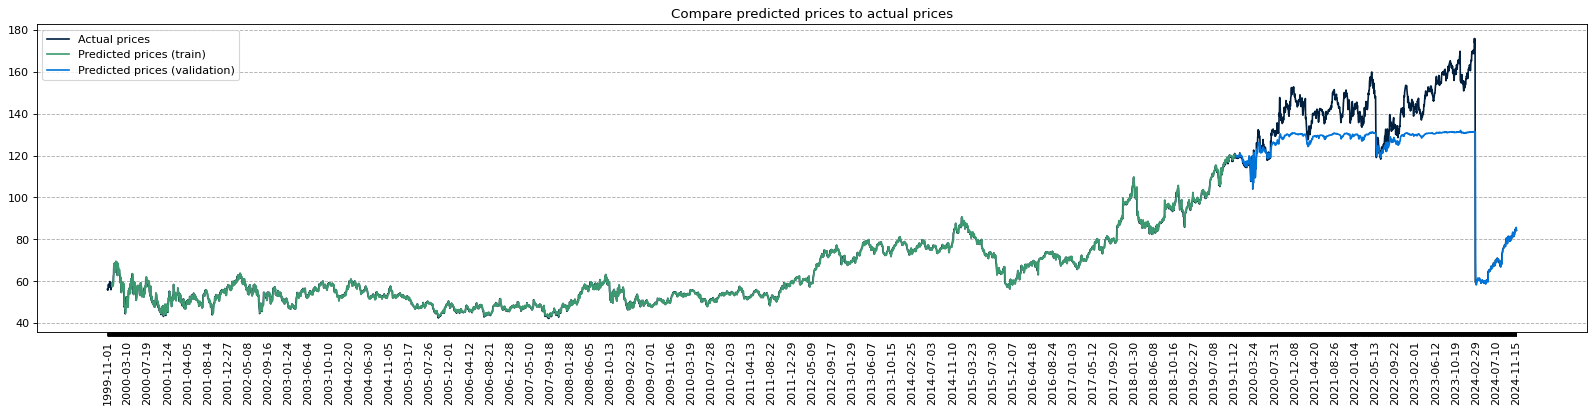

In [11]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
dates = data_date
train_dataloader = DataLoader(train_data, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(test_data, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train.reshape(-1, 1)).flatten()
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    # plt.plot(dates, data['Amazon'], label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(dates, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(dates, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(dates, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [dates[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # # prepare data for plotting, zoom in validation

    # to_plot_data_y_val_subset = scaler.inverse_transform(y_test[0].reshape(-1, 1)).flatten()
    # to_plot_predicted_val = scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()
    # to_plot_data_date = dates[split_index+config["data"]["window_size"]:]

    # # plots

    # fig = figure(figsize=(25, 5), dpi=80)
    # fig.patch.set_facecolor((1.0, 1.0, 1.0))
    # plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    # plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    # plt.title("Zoom in to examine predicted price on validation data portion")
    # xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    # xs = np.arange(0,len(xticks))
    # plt.xticks(xs, xticks, rotation='vertical')
    # plt.grid(which='major', axis='y', linestyle='--')
    # plt.legend()
    # plt.show()

# Model Inference

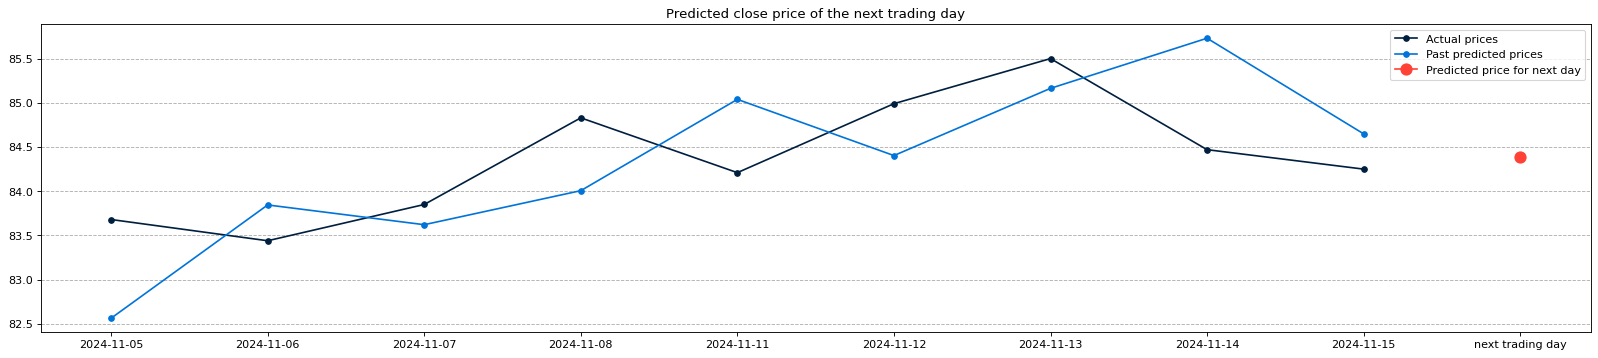

Predicted close price of the next trading day: 84.38


In [12]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(X_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction.reshape(-1,1)).flatten()[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val.reshape(-1,1)).flatten()[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = list(dates[-plot_range+1:])
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))


